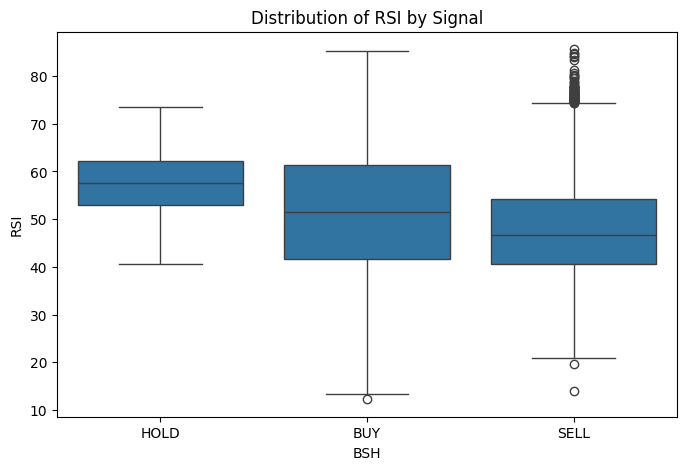

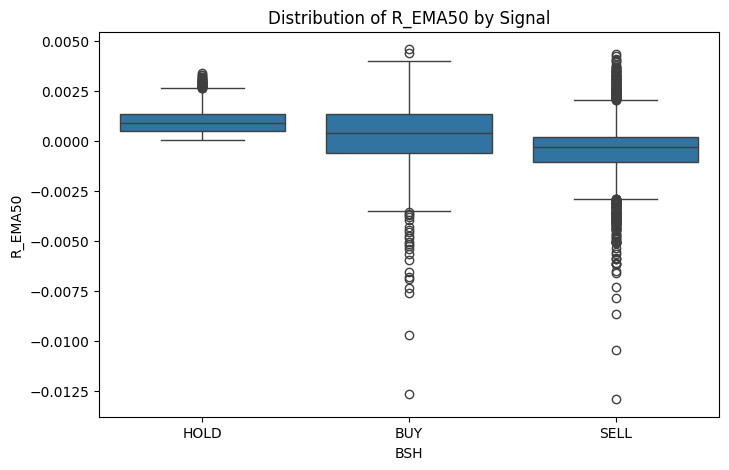

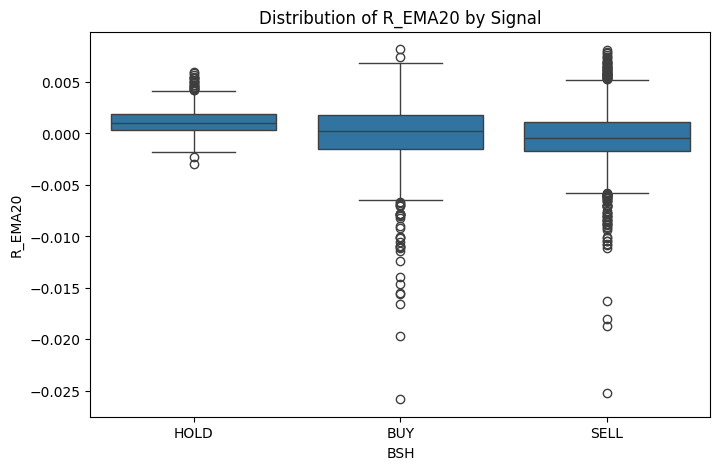

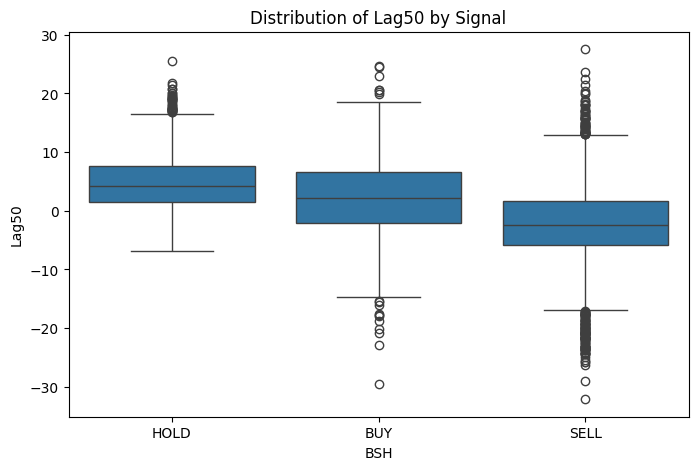

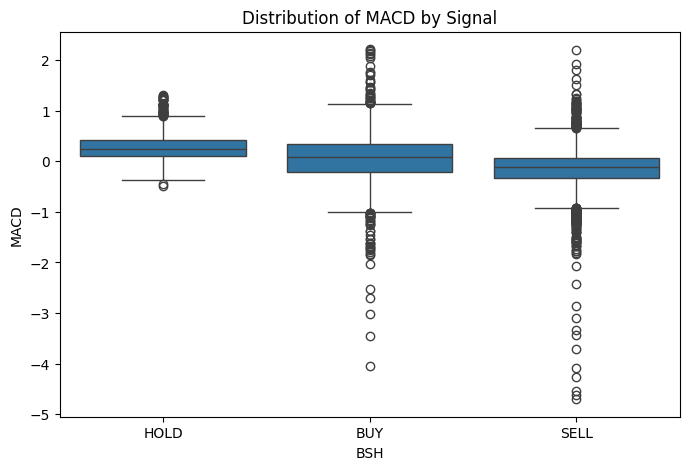

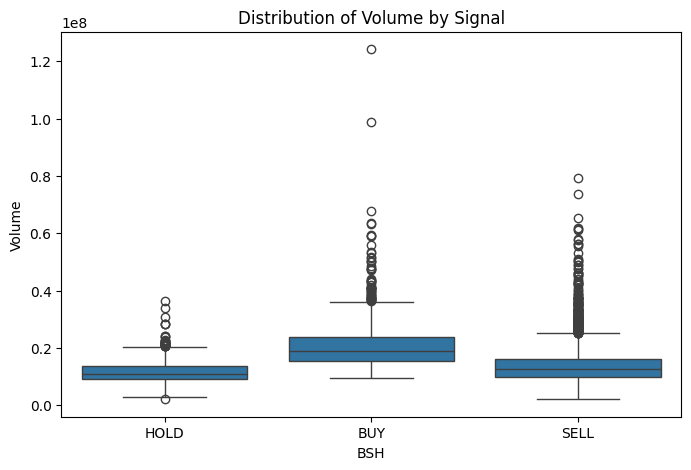

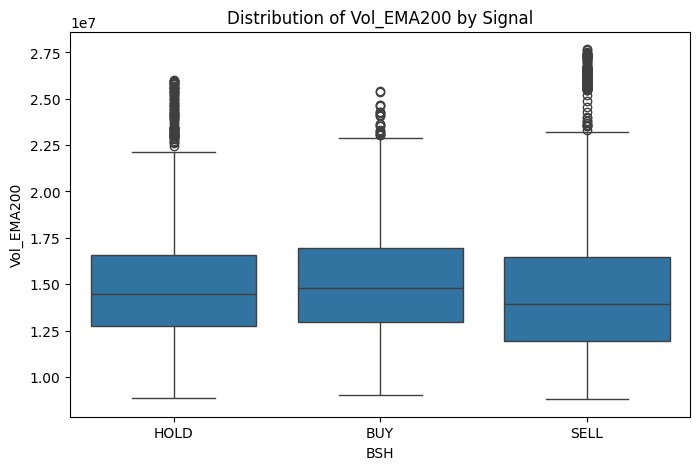

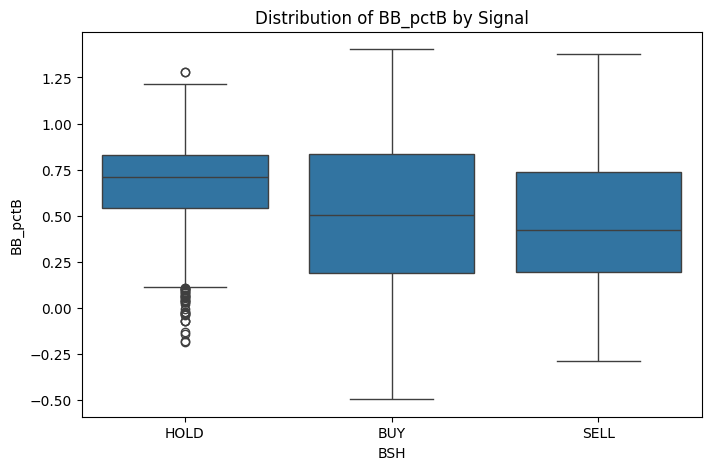

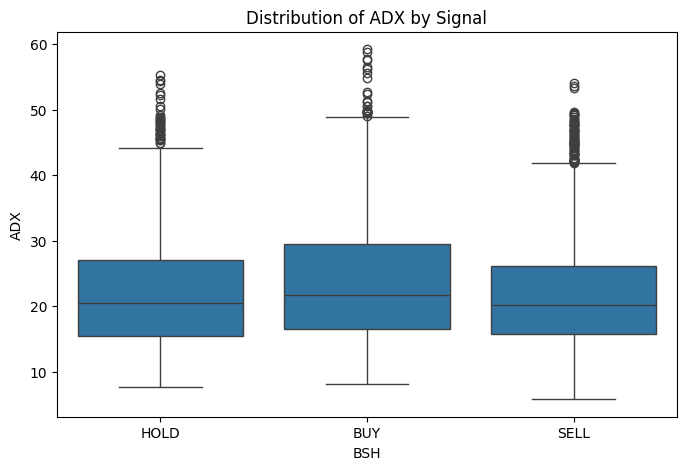

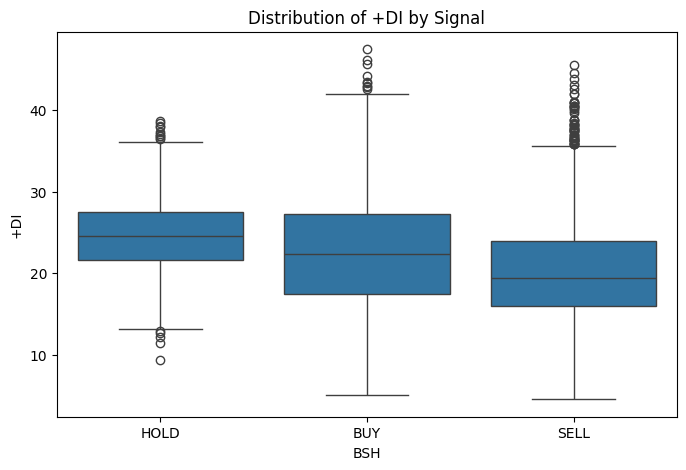

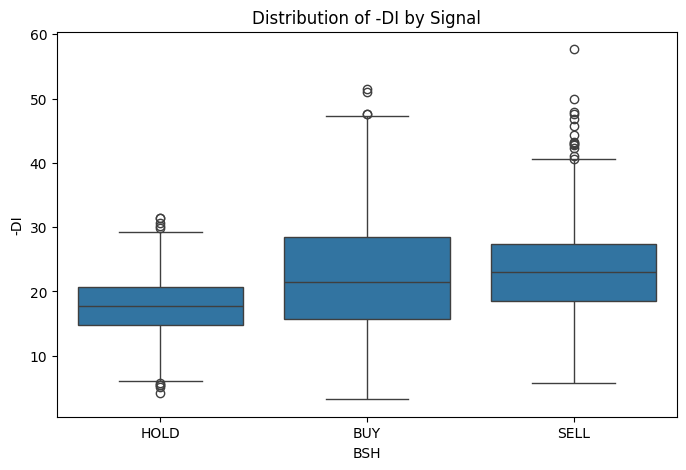

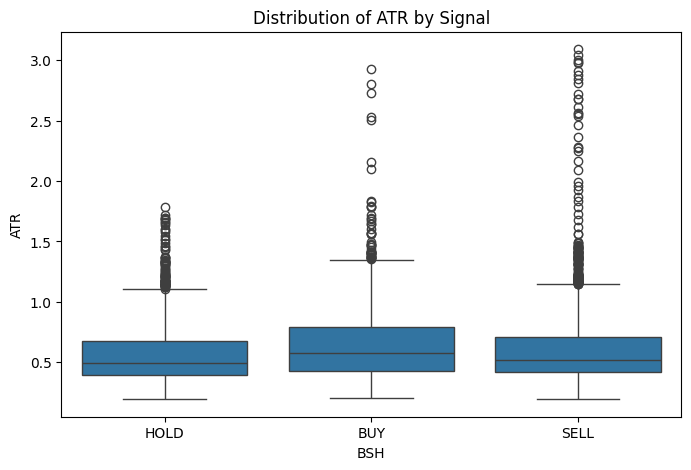

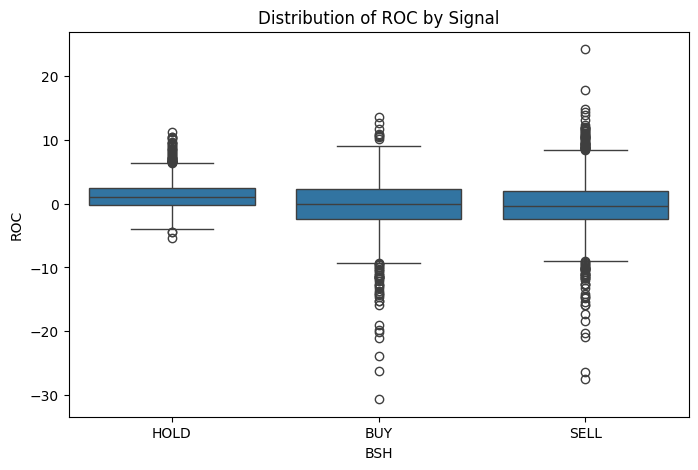

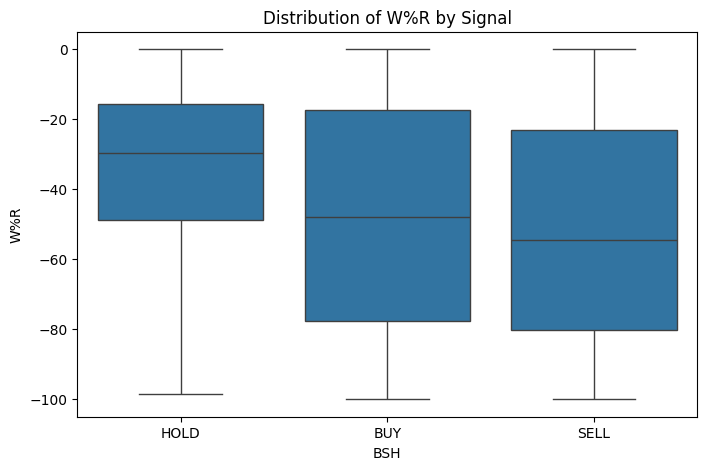

In [7]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier



TICKER = "KO"

# --- Carica dati ---
df = pd.read_csv(
    f"csv/{TICKER}_indicators.csv",
    index_col=0,
    parse_dates=[0],
    date_format="ISO8601"
)

#features = ["Lag1", "Lag10", "Lag15", "Lag50", "R_EMA50", "R_EMA10"]
features = ["RSI","R_EMA50","R_EMA20","Lag50","MACD","Volume","Vol_EMA200","BB_pctB",
            "ADX","+DI","-DI","ATR","ROC","W%R"]

# --- Features e target ---
X = df[features]
y = df["BSH"]




for feat in features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=y, y=df[feat])  # y = your labels (BUY/SELL/HOLD)
    plt.title(f"Distribution of {feat} by Signal")
    plt.show()



In [8]:
# Split temporale train/test
cutoff = "2025-01-01"  # adjust so test set is non-empty
X.index = pd.to_datetime(X.index)

cutoff = pd.to_datetime("2025-01-01")
train_mask = X.index < cutoff
test_mask = X.index >= cutoff

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]


bsh_counts = y_test.value_counts()
print(f"  Conteggio etichette per il test di {TICKER}:")
print(bsh_counts)
print(f"  Totale righe: {len(df)}")
print("-" * 40)




  Conteggio etichette per il test di KO:
BSH
SELL    67
BUY     59
HOLD    53
Name: count, dtype: int64
  Totale righe: 6269
----------------------------------------


[0.71264368 0.73399015 0.73891626 0.74876847 0.6683087  0.73070608
 0.69458128 0.77504105 0.70114943 0.71921182]


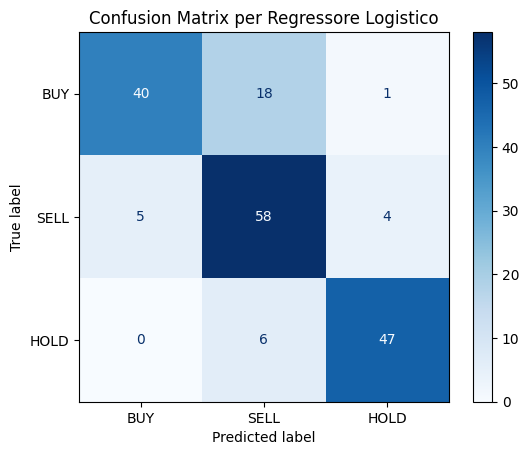

Classification report per Regressione Logistica:
              precision    recall  f1-score   support

         BUY       0.89      0.68      0.77        59
        SELL       0.71      0.87      0.78        67
        HOLD       0.90      0.89      0.90        53

    accuracy                           0.81       179
   macro avg       0.83      0.81      0.81       179
weighted avg       0.83      0.81      0.81       179



In [9]:
# Standardizzazione
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tentativo fallimentare di Oversampling
#smote = SMOTE(random_state=42)
#X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

#print("Class distribution after SMOTE:")
#print(pd.Series(y_res).value_counts())

# --- Logistic Regression ---
softmax_reg = LogisticRegression(max_iter=2000,solver="lbfgs",random_state=42)

print(cross_val_score(softmax_reg,X_train_scaled,y_train,cv=10,scoring="accuracy"))
softmax_reg.fit(X_train_scaled, y_train)

# Predizioni
y_pred = softmax_reg.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred, labels=["BUY","SELL","HOLD"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["BUY","SELL","HOLD"])
disp.plot(cmap = "Blues")
plt.title("Confusion Matrix per Regressore Logistico")
plt.show()

# Report di classificazione
print("Classification report per Regressione Logistica:")
print(classification_report(y_test, y_pred, labels=["BUY","SELL","HOLD"]))


Testing degli iperparametri su Random Forest

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [8, 12, 16, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for F1 instead of accuracy
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1,            # run in parallel
    verbose=2
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Cross-val scores (RF):
[0.65353038 0.60426929 0.73399015 0.68144499 0.7454844  0.85550082
 0.76190476 0.73727422 0.78489327 0.80131363]


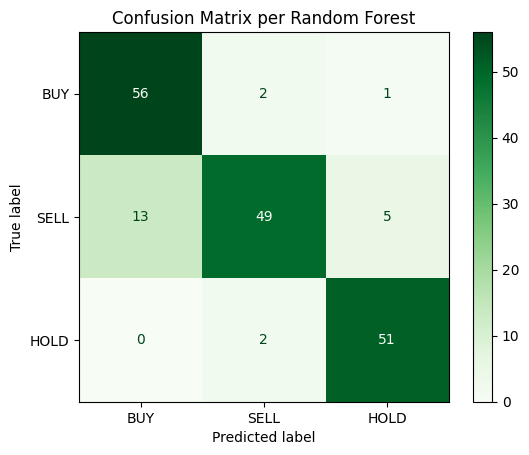

Classification report (Random Forest):
              precision    recall  f1-score   support

         BUY       0.81      0.95      0.88        59
        SELL       0.92      0.73      0.82        67
        HOLD       0.89      0.96      0.93        53

    accuracy                           0.87       179
   macro avg       0.88      0.88      0.87       179
weighted avg       0.88      0.87      0.87       179



In [10]:
# --- Random Forest ---
rf = RandomForestClassifier(
    n_estimators=300,      
    max_depth=None,        
    random_state=42,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features="sqrt",
    n_jobs=-1
)

# forests don’t need scaling, so use raw X_train, X_test
print("Cross-val scores (RF):")
print(cross_val_score(rf, X_train, y_train, cv=10, scoring="accuracy"))

rf.fit(X_train, y_train)

# Predizioni
y_pred_rf = rf.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["BUY","SELL","HOLD"])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["BUY","SELL","HOLD"])
disp_rf.plot(cmap="Greens")
plt.title("Confusion Matrix per Random Forest")
plt.show()

# Report di classificazione
print("Classification report (Random Forest):")
print(classification_report(y_test, y_pred_rf, labels=["BUY","SELL","HOLD"]))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 6090, number of used features: 14
[LightGBM] [Info] Start training from score -1.415958
[LightGBM] [Info] Start training from score -1.149128
[LightGBM] [Info] Start training from score -0.820085


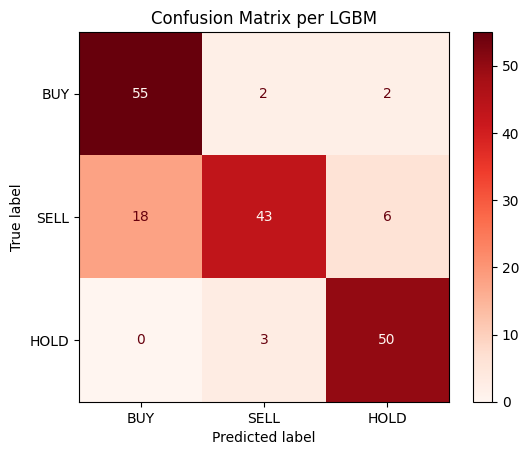

Classification Report per LGBM:
              precision    recall  f1-score   support

         BUY       0.75      0.93      0.83        59
        HOLD       0.86      0.94      0.90        53
        SELL       0.90      0.64      0.75        67

    accuracy                           0.83       179
   macro avg       0.84      0.84      0.83       179
weighted avg       0.84      0.83      0.82       179



In [11]:
lgbm = LGBMClassifier(
    n_estimators=200,
    max_depth=-1,          # no depth limit, trees controlled by leaves
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

# -----------------------------
# Evaluation
# -----------------------------
y_pred = lgbm.predict(X_test)


# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred, labels=["BUY","SELL","HOLD"])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["BUY","SELL","HOLD"])
disp_rf.plot(cmap="Reds")
plt.title("Confusion Matrix per LGBM")
plt.show()


print("Classification Report per LGBM:")
print(classification_report(y_test, y_pred))